In [699]:
import pandas as pd
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from time import time
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [700]:
# чтение CSV-файла и создание DataFrame
train_df = pd.read_csv("train.csv", index_col=0)
train_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0


In [701]:
# присоединение изначальных данных
origin_df = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)
origin_df = origin_df.dropna()
origin_df = origin_df[origin_df['stroke'] == 1]
print(len(train_df))
train_df = pd.concat([train_df, origin_df])
print(len(train_df))

# получаем случайный порядок индексов
idx = np.random.RandomState(seed=42).permutation(len(train_df))

# применяем порядок индексов к обоим DataFrame
train_df = train_df.iloc[idx].reset_index(drop=True)

15304
15513


In [702]:
train_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [703]:
#sns.barplot(x = "gender", y = "stroke", data = train_df)

In [704]:
#sns.barplot(x = "work_type", y = "stroke", data = train_df)

In [705]:
# fig, axes = plt.subplots(1, 2, figsize = (20, 6))

# sns.scatterplot(ax = axes[0], x = 'avg_glucose_level', y = 'bmi', data = train_df, hue = 'stroke')
# sns.scatterplot(ax = axes[1], x = 'avg_glucose_level', y = 'age', data = train_df, hue = 'stroke')

In [706]:
# fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# # Loop through each categorical feature and create a countplot on the corresponding subplot
# for i, feat in enumerate([
#     "gender",
#     "ever_married",
#     "work_type",
#     "Residence_type",
#     "smoking_status",
#     "glucose_levels",
# ]):
#     # Calculate the row and column indices for the subplot
#     row_idx, col_idx = divmod(i, 4)
    
#     # Create a countplot on the current subplot
#     sns.countplot(x=feat, data=train_df, palette='Set2', edgecolor='black', ax=axs[row_idx, col_idx])

#     # Set the title for the current subplot
#     axs[row_idx, col_idx].set_title(feat, size=18, y=1.03, fontname='Calibri',
#                                     fontweight='bold', color='#444444')
    
#     # rotate the class labels
#     axs[row_idx, col_idx].set_xticklabels(axs[row_idx, col_idx].get_xticklabels(), rotation=45)

# # hide last empty plot
# fig.delaxes(axs[1][3])


# # Add some padding between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

In [707]:
# Преобразуем гендер, статус замужества в числовое значение
train_df_clean = train_df.replace({'gender': {'Male': 0, 'Other': 0.5, 'Female': 1}})
train_df_clean = train_df_clean.replace({'ever_married': {'Yes': 1, 'No': 0}})
dummies = pd.get_dummies(train_df['work_type'], dtype=int)
train_df_clean = train_df_clean.drop('work_type', axis=1)
train_df_clean = pd.concat([train_df_clean, dummies], axis=1)
train_df_clean = train_df_clean.replace({'Residence_type': {'Urban': 1, 'Rural': 0}})
train_df_clean = train_df_clean.replace({'smoking_status': {'never smoked': 0, 'Unknown': 0.33, 'formerly smoked': 0.66, 'smokes': 1}})
train_df_clean

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed,children
0,1.0,44.00,0,0,1,1,87.95,26.3,0.33,0,1,0,0,0,0
1,1.0,75.00,0,0,1,1,78.16,34.5,0.00,1,0,0,0,1,0
2,1.0,23.00,0,0,0,1,82.64,41.8,0.00,0,0,0,1,0,0
3,0.0,0.56,0,0,0,0,56.33,14.1,0.33,0,0,0,0,0,1
4,0.0,44.00,0,0,1,0,56.11,27.6,0.00,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,0.0,45.00,0,0,1,1,120.56,31.6,0.00,0,1,0,0,0,0
15509,0.0,56.00,0,0,1,1,76.51,28.4,0.00,0,0,0,0,1,0
15510,1.0,31.00,0,0,1,0,82.57,30.7,1.00,0,0,0,1,0,0
15511,1.0,53.00,0,0,1,1,68.68,31.1,1.00,0,1,0,0,0,0


In [708]:
# пробуем добавить новые фичи (спойлер: толку нет)
# train_df_clean['age/bmi'] = train_df_clean.age / train_df_clean.bmi
# train_df_clean['age*bmi'] = train_df_clean.age * train_df_clean.bmi
# train_df_clean['bmi/prime'] = train_df_clean.bmi / 25
# train_df_clean['obesity'] = train_df_clean.avg_glucose_level * train_df_clean.bmi / 1000
# train_df_clean['blood_heart']= train_df_clean.hypertension*train_df_clean.heart_disease

<function matplotlib.pyplot.show(close=None, block=None)>

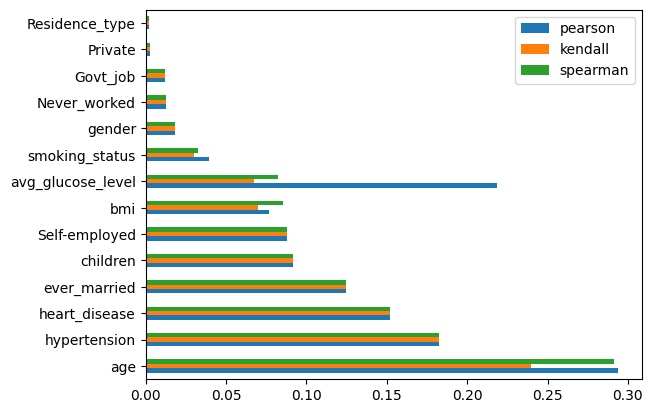

In [709]:
cpearson_corr = pd.Series.abs(train_df_clean.corr(method='pearson')['stroke']) # корреляция по методу Пирсона
kendall_corr = pd.Series.abs(train_df_clean.corr(method='kendall')['stroke']) # корреляция по методу Кендалла
spearman_corr = pd.Series.abs(train_df_clean.corr(method='spearman')['stroke']) # корреляция по методу Спирмена
corr_result = pd.concat([cpearson_corr, kendall_corr, spearman_corr], keys=['pearson', 'kendall', 'spearman'], axis=1)
corr_result = corr_result.sort_values(by='kendall', ascending=False)[1:]
corr_result

corr_result.plot.barh()
plt.show
# sns.barplot(x=corr_result, y=corr_result.index) # Create a bar plot to visualize the correlations
# plt.xlabel('Correlation with stroke') # Add a label to the x-axis of the plot
# plt.show()

In [710]:
# Проверка на наличие нормального распределения
columns_new = []
values_new = []
for column in train_df_clean.columns :
    p_value_factor = normaltest(train_df_clean[column]).pvalue
    columns_new.append(column)
    if p_value_factor > 0.05:
        values_new.append("+")
    else:
        values_new.append("-")
result = pd.DataFrame({'Фича': columns_new, 'имеет нормальное распределение': values_new})
result
# Проверка показала, что все поля не имеют нормального распределения,
# следовательно мы можем использвать либо корреляцию по методу Кендалла, либо по методу Спирмена.
# При этом, на таблице выше видно, что методы Кендалла и Спирмена имеют одинаковую последовательност


,Фича,имеет нормальное распределение
0,gender,-
1,age,-
2,hypertension,-
3,heart_disease,-
4,ever_married,-
5,Residence_type,-
6,avg_glucose_level,-
7,bmi,-
8,smoking_status,-
9,stroke,-


In [711]:
features = kendall_corr[(kendall_corr > 0) | (kendall_corr == 1)]
features.sort_values(ascending=False)[1:]
features = features.drop(['smoking_status', 'children', "gender", 'Private', 'Self-employed','heart_disease', 'bmi', 'Residence_type', 'Never_worked', 'Govt_job'])
features # возможно добавить 'hypertension'

age                  0.239788
hypertension         0.182460
ever_married         0.124595
avg_glucose_level    0.067071
stroke               1.000000
Name: stroke, dtype: float64

In [712]:
# избавление от незначащих фич
train_df_clean = train_df_clean.filter(features.index)
train_df_clean

,age,hypertension,ever_married,avg_glucose_level,stroke
0,44.00,0,1,87.95,0
1,75.00,0,1,78.16,1
2,23.00,0,0,82.64,0
3,0.56,0,0,56.33,0
4,44.00,0,1,56.11,0
...,...,...,...,...,...
15508,45.00,0,1,120.56,0
15509,56.00,0,1,76.51,0
15510,31.00,0,1,82.57,0
15511,53.00,0,1,68.68,0


In [713]:
# избавление от выбросов
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=1, min_samples=50)
# labels = dbscan.fit_predict(train_df_clean)
# filtered_data = train_df_clean[labels != -1]
# print(len(train_df_clean))
# print(len(filtered_data))
# train_df_clean_outlierless = filtered_data
# train_df_clean_outlierless
train_df_clean_outlierless = train_df_clean
train_df_clean

,age,hypertension,ever_married,avg_glucose_level,stroke
0,44.00,0,1,87.95,0
1,75.00,0,1,78.16,1
2,23.00,0,0,82.64,0
3,0.56,0,0,56.33,0
4,44.00,0,1,56.11,0
...,...,...,...,...,...
15508,45.00,0,1,120.56,0
15509,56.00,0,1,76.51,0
15510,31.00,0,1,82.57,0
15511,53.00,0,1,68.68,0


## Разделение dataFrame на тестовую и тренировочную выборки

In [714]:
# Очистка от лишних строк и подготовка данных
test_length_border = int(len(train_df_clean_outlierless) * 0.8)
test_df_clean_temp = train_df_clean_outlierless[test_length_border : ]
train_df_clean_temp = train_df_clean_outlierless[ : test_length_border]

# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(train_df_clean.drop(columns='stroke'), train_df_clean.loc[:, ['stroke']], random_state=2,test_size=0.2)
####
# print(len(train_df_clean_temp[train_df_clean_temp['stroke'] == 1]))
# train_minor = train_df_clean_temp[(train_df_clean_temp["stroke"] == 1)]
# train_major = train_df_clean_temp[(train_df_clean_temp["stroke"] == 0)]

# from sklearn.utils import resample, shuffle

# minor_upsampled = resample(train_minor, n_samples=int(len(train_minor)*1.6), random_state=7)

# train_df_clean_temp = pd.concat([minor_upsampled, train_major], ignore_index=True)
# train_df_clean_temp = shuffle(train_df_clean_temp,random_state=7)
# train_df_clean_temp.shape
# print(len(train_df_clean_temp[train_df_clean_temp['stroke'] == 1]))
#####

x_train = train_df_clean_temp.drop(columns='stroke')
y_train = train_df_clean_temp['stroke']

x_test = test_df_clean_temp.drop(columns='stroke')
y_test = test_df_clean_temp['stroke']

In [715]:
# from sklearn.model_selection import StratifiedKFold


# skf = StratifiedKFold(n_splits=10, shuffle=True)

# for train_index, test_index in skf.split(train_df_clean.drop(columns='stroke'), train_df_clean['stroke']):
#     x_train, x_test = train_df_clean.drop(columns='stroke').iloc[train_index], train_df_clean.drop(columns='stroke').iloc[test_index]
#     y_train, y_test = train_df_clean['stroke'].iloc[train_index], train_df_clean['stroke'].iloc[test_index]
# print(len(y_test[y_test == 1]))
# print(len(y_train))

In [716]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(x_train)

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train/2)
# plt.show()

In [717]:
# выравнивание классов
import numpy as np

# субдескретизация уменьшением элементов до k где stroke = 0
k = 0.7
random_state = 42
zero_idx = np.array(y_train[y_train == 0].index)
subset_idx = np.random.RandomState(random_state).choice(zero_idx, size=int(k*len(zero_idx)), replace=False)

one_idx = np.array(y_train[y_train == 1].index)
c = np.concatenate((subset_idx, one_idx), axis=0)
x_train = x_train.loc[c].sort_index()
y_train = y_train.loc[c].sort_index()
print(len(x_train))

# передискретизация дублированием n раз элементов где stroke = 1
n = 0
for i in range(n) :
    x_train = np.concatenate((x_train, x_train.loc[one_idx]))
    y_train = np.concatenate((y_train, y_train.loc[one_idx]))
    print(len(x_train))
# не везде работает

# избавление от связей Томека (без импакта)
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
print(len(x_train))
x_tomek, y_tomek = tomek.fit_resample(x_train, y_train)
x_train, y_train = x_tomek, y_tomek
print(len(x_tomek))

# сосредоточение к ближайшим соседям (долго думает)
# from imblearn.under_sampling import CondensedNearestNeighbour
# cnn = CondensedNearestNeighbour(random_state=42) 
# print(len(x_train))
# x_tomek, y_tomek = cnn.fit_resample(x_train, y_train)
# x_train, y_train = x_tomek, y_tomek
# print(len(x_tomek))

8890
8890
8649


In [718]:

print(len(x_train))
print(len(y_train))

8649
8649


#### SMOTE

In [719]:
# генерация искусственных данных с помощью SMOTE
smote = SMOTE(sampling_strategy=0.1, random_state=8765)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(len(x_train_smote))
print("теперь равно нулю: ", len(y_train_smote[y_train_smote==0]))
print("изначально равно нулю: ", len(y_train[y_train==0]))
print("теперь равно еденице: ", len(y_train_smote[y_train_smote==1]))
print("изначально равно еденице: ", len(y_train[y_train==1]))
x_train = x_train_smote
y_train = y_train_smote

8767
теперь равно нулю:  7970
изначально равно нулю:  7970
теперь равно еденице:  797
изначально равно еденице:  679


In [720]:
from sklearn.preprocessing import StandardScaler
# import seaborn
# pff = pd.concat([x_train, y_train], axis=1)
# seaborn.pairplot(pff, hue='stroke')

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
#x_train = pd.concat((x_train, x_train), axis=0)

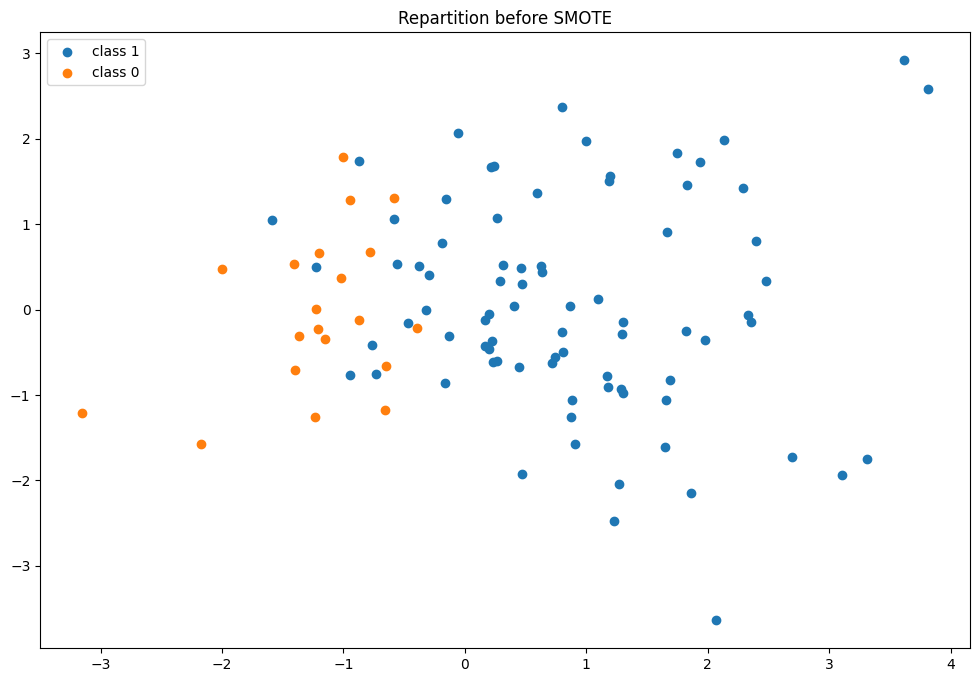

In [721]:
# тесты
x_sample_train, y_sample_train = make_classification(n_samples=100, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2, weights=[0.2, 0.8],
                           class_sep=0.95, random_state=0)

plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(x_sample_train[y_sample_train == 1][:, 0], x_sample_train[y_sample_train == 1][:, 1], label='class 1')
plt.scatter(x_sample_train[y_sample_train == 0][:, 0], x_sample_train[y_sample_train == 0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

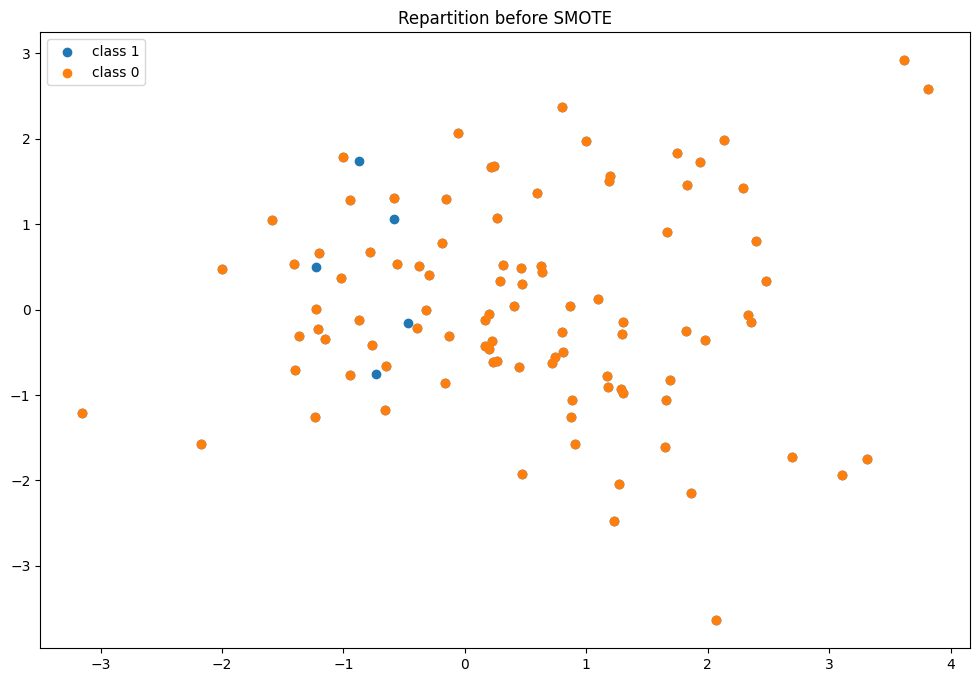

In [722]:



# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# labels = dbscan.fit_predict(x_sample_train)
# filtered_data = x_sample_train[labels != -1]
# print(len(x_sample_train))
# print(len(filtered_data))

from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(x_sample_train, y_sample_train)


plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(x_sample_train[:, 0], x_sample_train[:, 1], label='class 1')
plt.scatter(X_tomek[:, 0], X_tomek[:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

## Обучение моделей

In [723]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn import metrics

def print_error_matrix(y_test, y_pred) :
    data = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
    print(data)
    ax = sns.heatmap(data, annot=True, fmt="d")
    plt.title("Матрица ошибок", fontsize=12)
    plt.xlabel('predict') 
    plt.ylabel('test') 
    plt.show()

def print_metrics(y_test, y_pred) : 
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Precision:", precision, "    Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1:", f1)
    
def print_score(model, x_test) :
    score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    print("Score:", score)


In [724]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

# создаем объект модели
nb = GaussianNB()

nb.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = nb.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
# naive bayes precision:  0.17777777777777778 predict_proba
# Accuracy: 0.9353152564521399
# Recall: 0.21621621621621623
# F1: 0.1951219512195122
# roc_auc:  0.5892945487860742


Precision: 0.2782608695652174     Recall: 0.3950617283950617
Accuracy: 0.9149210441508218
F1: 0.326530612244898


Precision: 0.44     Recall: 0.2037037037037037
Accuracy: 0.9448920399613278
F1: 0.27848101265822783
Score: 0.8661054231155104
[[2899   42]
 [ 129   33]]


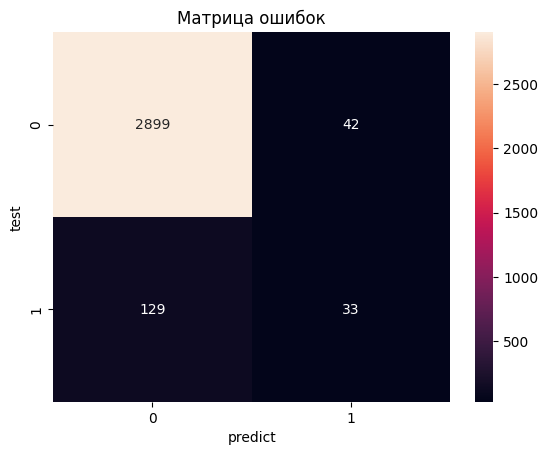

In [725]:
from sklearn.linear_model import LogisticRegression

# создаем объект модели
lr_model = LogisticRegression(solver="newton-cg")

# обучаем модель на обучающей выборке
lr_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = lr_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
print_score(lr_model, x_test)

print_error_matrix(y_test, y_pred)

# LogisticRegression precision:  0.3050847457627119
# Accuracy: 0.9562234563868017
# Recall: 0.16216216216216217
# F1: 0.21176470588235297
# roc_auc:  0.5741319285387083

In [726]:
from sklearn.tree import DecisionTreeClassifier

# создаем объект модели
lr_model = DecisionTreeClassifier()

# обучаем модель на обучающей выборке
lr_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = lr_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)

# DecisionTreeClassifier precision:  0.19411764705882353
# Accuracy: 0.9297615158444953
# Recall: 0.2972972972972973
# F1: 0.23487544483985764

Precision: 0.2217741935483871     Recall: 0.3395061728395062
Accuracy: 0.9033193683532066
F1: 0.2682926829268293


In [727]:
from sklearn.ensemble import RandomForestClassifier

# создаем объект модели
rf_model = RandomForestClassifier()

# обучаем модель на обучающей выборке
rf_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)

# DecisionTreeClassifier precision:  0.19411764705882353
# Accuracy: 0.9297615158444953
# Recall: 0.2972972972972973
# F1: 0.23487544483985764

Precision: 0.2777777777777778     Recall: 0.37037037037037035
Accuracy: 0.9168546567837577
F1: 0.3174603174603175


Precision: 0.4117647058823529     Recall: 0.25925925925925924
Accuracy: 0.9419916210119239
F1: 0.3181818181818182
Score: 0.8701951129413444
[[2881   60]
 [ 120   42]]


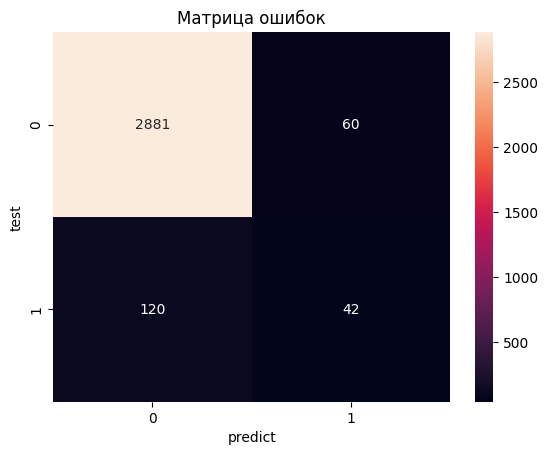

,cols,imp
0,age,253
3,avg_glucose_level,214
2,ever_married,20
1,hypertension,13


In [728]:
from lightgbm import LGBMClassifier

lgbm_hyperparameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2,],
    'num_leaves': [2, 6, 10, 14, 18, 20],
    'max_depth': [2, 6, 8,  12,  16,  20],
    'min_child_samples': [2, 4,  8, 12, 16,  20],
    'subsample': [0.5, 0.6, 0.8, 1],
}
# clf = LGBMClassifier(random_state=seed, n_jobs=-1)
# grid_search = GridSearchCV(clf, lgbm_hyperparameters, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(train_X, train_y)
# print(grid_search.best_params_)

best_params_lgbm = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 12, 'n_estimators': 100, 'num_leaves': 6, 'subsample': 0.5}
lgbm_model = LGBMClassifier(random_state=321, n_jobs=-1, **best_params_lgbm)
lgbm_model.fit(x_train, y_train)


# делаем прогнозы на тестовой выборке
y_pred = lgbm_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
print_score(lgbm_model, x_test)

print_error_matrix(y_test, y_pred)
# LGBMClassifier precision:  0.38
# Accuracy: 0.9598170532505718
# Recall: 0.17117117117117117
# F1: 0.2360248447204969
fi = pd.DataFrame({
    'cols': x_train.columns,
    'imp': lgbm_model.feature_importances_
}).sort_values('imp', ascending=False)
fi


In [729]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Создаем модель RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающей выборке
model_rf.fit(x_train, y_train)

# Выполняем предсказание на тестовой выборке
y_pred = model_rf.predict(x_test)

# Вычисляем метрики качества модели
print_metrics(y_test, y_pred)

# precision:  0.23
# Accuracy: 0.94
# Recall: 0.26
# F1: 0.24

Precision: 0.27102803738317754     Recall: 0.35802469135802467
Accuracy: 0.9162101192394457
F1: 0.30851063829787234


In [730]:
from xgboost import XGBClassifier
# Создаем модель XGBClassifier
model_xgb = XGBClassifier(n_estimators=800, random_state=45, max_depth=2, colsample_bytree=0.5, subsample=0.85, eta=0.3)

# Обучаем модель на обучающей выборке
model_xgb.fit(x_train, y_train)

# Выполняем предсказание на тестовой выборке
y_pred = model_xgb.predict(x_test)

# Вычисляем метрики качества модели
print_metrics(y_test, y_pred)
print_score(model_xgb, x_test)
# precision:  0.26
# Accuracy: 0.95
# Recall: 0.25
# F1: 0.26

Precision: 0.336     Recall: 0.25925925925925924
Accuracy: 0.9345794392523364
F1: 0.2926829268292683
Score: 0.860711272305968


In [731]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Создаем модель CatBoostClassifier
model_cb = CatBoostClassifier(n_estimators=100, random_state=66, depth=4, logging_level='Silent')

# Обучаем модель на обучающей выборке
model_cb.fit(x_train, y_train)

# Выполняем предсказание на тестовой выборке
y_pred = model_cb.predict(x_test)

print_metrics(y_test, y_pred)
print_score(model_cb, x_test)

# # Вычисляем метрики качества модели
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

# Precision: 0.41935483870967744
# Accuracy: 0.9604704344985299
# recall: 0.23423423423423423
# f1: 0.30057803468208094

Precision: 0.4017094017094017     Recall: 0.29012345679012347
Accuracy: 0.940380277151144
F1: 0.3369175627240143
Score: 0.8738534805915517


In [732]:
for key,value in model_cb.get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, Logloss
iterations, 100
sampling_frequency, PerTree
leaf_estimation_method, Newton
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, False
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.800000011920929
use_best_model, False
class_names, [0, 1]
random_seed, 66
depth, 4
posterior_sampling, False
border_count, 254
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, Logloss
learning_rate, 0.2150460034608841
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_type, MVS
max_leaves, 16


In [733]:
from fastcore.parallel import *
from statistics import mean

scores = []

def do_step(n):
    n = n/100

    model_cb = CatBoostClassifier(n_estimators=100, random_state=66, depth=4, logging_level='Silent', eta=0.3)
    model_cb.fit(x_train, y_train)
    y_pred = model_cb.predict(x_test)

    scores.append([n, f1_score(y_test, y_pred)])
    print(n)

parallel(do_step, list(range(1, 100, 10)), n_workers=8)

scores = pd.DataFrame(scores)
scores.set_index(0, inplace=True)
print('Max: \n', scores[scores[1] == scores[1].max()])
print('Mean: ', scores[1].mean())
scores

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
0.01
0.11
0.21
0.31
0.41
0.51
0.61
0.71
0.81
0.91
Max: 
              1
0             
0.01  0.325088
0.11  0.325088
0.21  0.325088
0.31  0.325088
0.41  0.325088
0.51  0.325088
0.61  0.325088
0.71  0.325088
0.81  0.325088
0.91  0.325088
Mean:  0.3250883392226148


,1
0,
0.01,0.325088
0.11,0.325088
0.21,0.325088
0.31,0.325088
0.41,0.325088
0.51,0.325088
0.61,0.325088
0.71,0.325088
0.81,0.325088


In [734]:
test = [[1,2,3],[1,2,3]]
test2 = pd.DataFrame(test)
test2.set_index(1, inplace=True)
print(test2)

   0  2
1      
2  1  3
2  1  3


In [735]:
fi = pd.DataFrame({
    'cols': x_train.columns,
    'imp': model_cb.feature_importances_
}).sort_values('imp', ascending=False)
fi

,cols,imp
0,age,66.988644
3,avg_glucose_level,22.893911
2,ever_married,8.446745
1,hypertension,1.670700


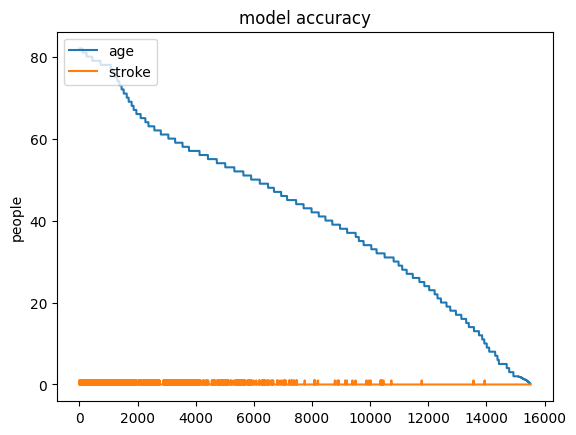

In [736]:
import matplotlib.pyplot as plt

draw_dp = train_df.sort_values(by='age', ascending=False)
plt.plot(range(len(draw_dp)), draw_dp['age'], )
plt.plot(range(len(draw_dp)), draw_dp['stroke'])
plt.title('model accuracy')
plt.ylabel('people')
plt.legend(['age', 'stroke'], loc='upper left')
plt.show()

841
14672


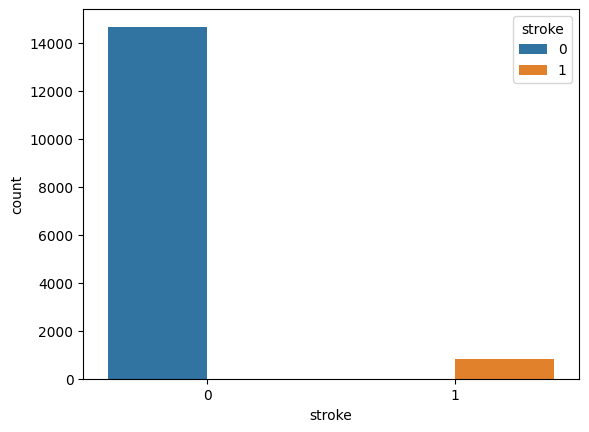

In [737]:

sns.countplot(x = 'stroke', hue = 'stroke', data = train_df)
print(len(train_df[train_df['stroke'] > 0]))
print(len(train_df[train_df['stroke'] == 0]))

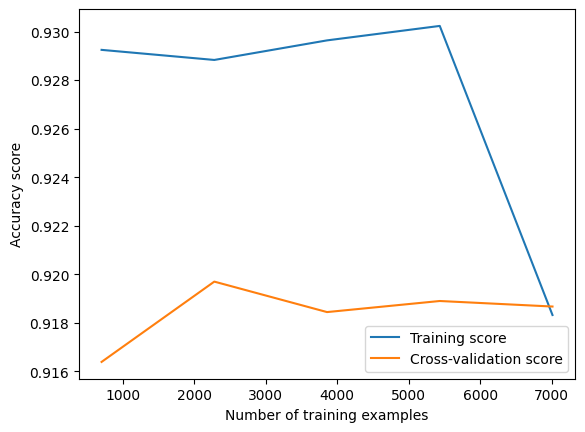

In [738]:
from sklearn.model_selection import learning_curve
# Создадим объект LogisticRegression
logreg = LogisticRegression()

# Определим значения для тренировочных и проверочных данных
# В данном примере будем использовать 5 разбиений
train_sizes, train_scores, test_scores = learning_curve(logreg, x_train, y_train, cv=5)

# Вычислим средние значения по всем тренировочным и проверочным данным
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Создадим график
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

# for i in y_train.values: 
#     print(y_train[12000:])

In [739]:
print("naive bayes precision: ", GaussianNBPrecision)
print("LogisticRegression precision: ", LogisticRegressionPrecision)
print("DecisionTreeClassifier precision: ", DecisionTreeClassifierPrecision)
print("LGBMClassifier precision: ", LGBMClassifierPrecision)

NameError: name 'GaussianNBPrecision' is not defined